In [ ]:
!pip install pylorentz --user

In [1]:
import uproot 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.spatial.transform import Rotation as R
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from pylorentz import Momentum4
from pylorentz import Position4

In [1]:
# tree_tt = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_tt.root")["ntuple"]
tree_tt = uproot.open("/eos/user/s/stcheung/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_tt.root")["ntuple"]
print('loaded root file')
variables = [
            "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
            "aco_angle_1", "aco_angle_5", "aco_angle_6", "aco_angle_7", 
            "mva_dm_1","mva_dm_2",
            "tau_decay_mode_1","tau_decay_mode_2",
            "ip_x_1", "ip_y_1", "ip_z_1", "ip_x_2", "ip_y_2", "ip_z_2", # ignore impact parameter for now
            "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1", 
            "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2", 
            "pi0_E_1", "pi0_px_1", "pi0_py_1", "pi0_pz_1",
            "pi0_E_2", "pi0_px_2", "pi0_py_2", "pi0_pz_2", 
            "y_1_1", "y_1_2",
            'met', 'metx', 'mety',
            'metCov00', 'metCov01', 'metCov10', 'metCov11'
            'sv_x_1', 'sv_y_1', 'sv_z_1', 'sv_x_2', 'sv_y_2','sv_z_2'
        ]

variables += ["gen_nu_p_1", "gen_nu_phi_1", "gen_nu_eta_1", #leading neutrino, gen level
            "gen_nu_p_2", "gen_nu_phi_2", "gen_nu_eta_2" #subleading neutrino, gen level
             ]

df_tt = tree_tt.pandas.df(variables)
print('loaded df')
# select only rho-rho events
df_rho = df[(df['mva_dm_1']==1) & (df['mva_dm_2']==1) & (df["tau_decay_mode_1"] == 1) & (df["tau_decay_mode_2"] == 1)]
# drop unnecessary labels 
df = df_rho.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2", "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)
print('finished rho-rho loading')

NameError: name 'uproot' is not defined

In [ ]:
# gen level data
tree_tt_gen = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_GEN_AllHiggs_tt.root")["ntuple"]
variables_gen = [
            "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
            "dm_1", "dm_2",
            "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1", # charged pion 1
            "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2", # charged pion 2
            "pi0_E_1", "pi0_px_1", "pi0_py_1", "pi0_pz_1", # neutral pion 1
            "pi0_E_2", "pi0_px_2", "pi0_py_2", "pi0_pz_2", # neutral pion 2,
            'metx', 'mety',
            ]
df_tt_gen = tree_tt_gen.pandas.df(variables_gen)
df_rho = df_tt_gen[(df_tt_gen['dm_1']==1) & (df_tt_gen['dm_2']==1)]

In [ ]:
df_tt_gen.to_pickle('./df_tt_gen.pkl')

In [ ]:
df_tt_gen = pd.read_pickle('./df_tt_gen.pkl')

In [ ]:
df_tt.to_pickle('./df_tt.pkl')

In [2]:
df_tt = pd.read_pickle('df_tt.pkl')

In [3]:
channel = 'rho_rho'

In [4]:
# reco level data
if channel == 'rho_rho':
    df_rho = df_tt[(df_tt['mva_dm_1']==1) & (df_tt['mva_dm_2']==1) & (df_tt["tau_decay_mode_1"] == 1) & (df_tt["tau_decay_mode_2"] == 1)]
    df = df_rho.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2", "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)
elif channel == 'rho_a1':
    df_rho_a1 = df_tt[(df_tt['mva_dm_1']==1) & (df_tt['mva_dm_2']==10) & (df_tt["tau_decay_mode_1"] == 1)]
    df = df_rho_a1.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2", "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)
elif channel == 'a1_a1':
    df_a1_a1 = df_tt[(df_tt['mva_dm_1']==10) & (df_tt['mva_dm_2']==10)]
    df = df_a1_a1.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2", "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)    
else:
    print('CHANNEL not understood!')

In [ ]:
# gen level data NEED TO CHECK FOR TAU DECAY MODE LABEL
if channel == 'rho_rho':
    df_rho = df_tt_gen[(df_tt_gen['dm_1']==1) & (df_tt_gen['dm_2']==1)]
    df = df_rho.drop(["dm_1","dm_2","wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)
elif channel == 'rho_a1':
    df_rho_a1 = df_tt_gen[(df_tt_gen['dm_1']==1) & (df_tt_gen['dm_2']==10)]
    df = df_rho_a1.drop(["dm_1","dm_2","wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)
elif channel == 'a1_a1':
    df_a1_a1 = df_tt_gen[(df_tt_gen['dm_1']==10) & (df_tt_gen['dm_2']==10)]
    df = df_a1_a1.drop(["dm_1","dm_2","wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)
else:
    print('CHANNEL not understood!')
df['met'] = np.sqrt(df['metx']**2+df['mety']**2)

In [ ]:
df.head()

In [ ]:
# y = (~(df_rho["rand"]<df_rho["wt_cp_ps"]/2).to_numpy()).astype(int)
# np.save('./potential_2016/y_kristof', y, allow_pickle=True)

In [5]:
N = len(df['metx'])
met_x = Momentum4(df['metx'], np.zeros(N), np.zeros(N), np.zeros(N))
met_y = Momentum4(df['mety'], np.zeros(N), np.zeros(N), np.zeros(N))
met = Momentum4(df['met'], np.zeros(N), np.zeros(N), np.zeros(N))

In [6]:
pi_1 = Momentum4(df['pi_E_1'], df["pi_px_1"], df["pi_py_1"], df["pi_pz_1"])
pi_2 = Momentum4(df['pi_E_2'], df["pi_px_2"], df["pi_py_2"], df["pi_pz_2"])
pi0_1 = Momentum4(df['pi0_E_1'], df["pi0_px_1"], df["pi0_py_1"], df["pi0_pz_1"])
pi0_2 = Momentum4(df['pi0_E_2'], df["pi0_px_2"], df["pi0_py_2"], df["pi0_pz_2"])
rho_1 = pi_1 + pi0_1
rho_2 = pi_2 + pi0_2
# rho_1.m is invariant mass of rhos
# boost into rest frame of resonances
rest_frame = pi_1 + pi_2 + pi0_1 + pi0_2
boost = Momentum4(rest_frame[0], -rest_frame[1], -rest_frame[2], -rest_frame[3])
pi_1_boosted = pi_1.boost_particle(boost)
pi_2_boosted = pi_2.boost_particle(boost)
pi0_1_boosted = pi0_1.boost_particle(boost)
pi0_2_boosted = pi0_2.boost_particle(boost)
rho_1_boosted = pi_1_boosted + pi0_1_boosted
rho_2_boosted = pi_2_boosted + pi0_2_boosted
# boost MET
met_x_boosted = met_x.boost_particle(boost)
met_y_boosted = met_y.boost_particle(boost)
met_boosted = met.boost_particle(boost)

In [7]:
# rotations
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix
    
pi_1_boosted_rot = []
pi_2_boosted_rot = []
pi0_1_boosted_rot = []
pi0_2_boosted_rot = []
rho_1_boosted_rot = []
rho_2_boosted_rot = []
for i in range(pi_1_boosted[:].shape[1]):
    rot_mat = rotation_matrix_from_vectors(rho_1_boosted[1:, i], [0,0,1])
    pi_1_boosted_rot.append(rot_mat.dot(pi_1_boosted[1:, i]))
    pi0_1_boosted_rot.append(rot_mat.dot(pi0_1_boosted[1:, i]))
    pi_2_boosted_rot.append(rot_mat.dot(pi_2_boosted[1:, i]))
    pi0_2_boosted_rot.append(rot_mat.dot(pi0_2_boosted[1:, i]))
    rho_1_boosted_rot.append(rot_mat.dot(rho_1_boosted[1:, i]))
    rho_2_boosted_rot.append(rot_mat.dot(rho_2_boosted[1:, i]))
    if i%100000==0:
        print('finished getting rotated 4-vector', i)
        

finished getting rotated 4-vector 0
finished getting rotated 4-vector 100000
finished getting rotated 4-vector 200000
finished getting rotated 4-vector 300000
finished getting rotated 4-vector 400000
finished getting rotated 4-vector 500000
finished getting rotated 4-vector 600000
finished getting rotated 4-vector 700000
finished getting rotated 4-vector 800000
finished getting rotated 4-vector 900000


In [8]:
pi_1_boosted_rot = np.array(pi_1_boosted_rot)
pi_2_boosted_rot = np.array(pi_2_boosted_rot)
pi0_1_boosted_rot = np.array(pi0_1_boosted_rot)
pi0_2_boosted_rot = np.array(pi0_2_boosted_rot)
rho_1_boosted_rot = np.array(rho_1_boosted_rot)
rho_2_boosted_rot = np.array(rho_2_boosted_rot)

In [46]:
df.columns

Index(['aco_angle_1', 'aco_angle_5', 'aco_angle_6', 'aco_angle_7', 'ip_x_1',
       'ip_y_1', 'ip_z_1', 'ip_x_2', 'ip_y_2', 'ip_z_2', 'pi_E_1', 'pi_px_1',
       'pi_py_1', 'pi_pz_1', 'pi_E_2', 'pi_px_2', 'pi_py_2', 'pi_pz_2',
       'pi0_E_1', 'pi0_px_1', 'pi0_py_1', 'pi0_pz_1', 'pi0_E_2', 'pi0_px_2',
       'pi0_py_2', 'pi0_pz_2', 'y_1_1', 'y_1_2', 'met', 'metx', 'mety',
       'metcov00', 'metcov01', 'metcov10', 'metcov11', 'gen_nu_p_1',
       'gen_nu_phi_1', 'gen_nu_eta_1', 'gen_nu_p_2', 'gen_nu_phi_2',
       'gen_nu_eta_2'],
      dtype='object')

In [78]:
# create new dataframe to store this new inputs
df_new_data = {
    'pi_E_1_br': pi_1_boosted[0],
    'pi_px_1_br': pi_1_boosted_rot[:,0],
    'pi_py_1_br': pi_1_boosted_rot[:,1],
    'pi_pz_1_br': pi_1_boosted_rot[:,2],
    'pi_E_2_br': pi_2_boosted[0],
    'pi_px_2_br': pi_2_boosted_rot[:,0],
    'pi_py_2_br': pi_2_boosted_rot[:,1],
    'pi_pz_2_br': pi_2_boosted_rot[:,2],
    'pi0_E_1_br': pi0_1_boosted[0],
    'pi0_px_1_br': pi0_1_boosted_rot[:,0],
    'pi0_py_1_br': pi0_1_boosted_rot[:,1],
    'pi0_pz_1_br': pi0_1_boosted_rot[:,2],
    'pi0_E_2_br': pi0_2_boosted[0],
    'pi0_px_2_br': pi0_2_boosted_rot[:,0],
    'pi0_py_2_br': pi0_2_boosted_rot[:,1],
    'pi0_pz_2_br': pi0_2_boosted_rot[:,2],
    'y_1_1': df.y_1_1,
    'y_1_2': df.y_1_2,
    'aco_angle_1': df.aco_angle_1,
    'm_1': rho_1.m,
    'm_2': rho_2.m,
    'gen_nu_px_1_br': nu_1_boosted_rot[:,0],
    'gen_nu_py_1_br': nu_1_boosted_rot[:,1],
    'gen_nu_pz_1_br': nu_1_boosted_rot[:,2],
    'gen_nu_px_2_br': nu_2_boosted_rot[:,0],
    'gen_nu_py_2_br': nu_2_boosted_rot[:,1],
    'gen_nu_pz_2_br': nu_2_boosted_rot[:,2],
}
df_new = pd.DataFrame(data=df_new_data)
df_new.to_pickle('./df_saved/rho_rho/df_rho_rho.pkl')

In [41]:
pi_1_boosted[0]

array([38.86624918, 17.17515037,  8.52699315, ..., 48.08895789,
        1.97226794, 15.00650155])

In [12]:
np.save('reco_info/rho_rho/pi_1_boosted_rot.npy', pi_1_boosted_rot, allow_pickle=True)
np.save('reco_info/rho_rho/pi_2_boosted_rot.npy', pi_2_boosted_rot, allow_pickle=True)
np.save('reco_info/rho_rho/pi0_1_boosted_rot.npy', pi0_1_boosted_rot, allow_pickle=True)
np.save('reco_info/rho_rho/pi0_2_boosted_rot.npy', pi0_2_boosted_rot, allow_pickle=True)

In [8]:
pi_1_boosted_rot = np.load('reco_info/rho_rho/pi_1_boosted_rot.npy', allow_pickle=True)
pi_2_boosted_rot = np.load('reco_info/rho_rho/pi_2_boosted_rot.npy', allow_pickle=True)
pi0_1_boosted_rot = np.load('reco_info/rho_rho/pi0_1_boosted_rot.npy', allow_pickle=True)
pi0_2_boosted_rot = np.load('reco_info/rho_rho/pi0_2_boosted_rot.npy', allow_pickle=True)

In [15]:
E_miss_boosted = met_boosted[0]
E_miss_x_boosted = met_x_boosted[0]
E_miss_y_boosted = met_y_boosted[0]

In [ ]:
# to_load = []
# to_load_names = ["pi_1_transformed", "pi_2_transformed", "pi0_1_transformed", "pi0_2_transformed", "rho_1_transformed", "rho_2_transformed", "aco_angle_1", "y_1_1", "y_1_2", "m_1", "m_2", "w_a", "w_b"]
# for i in range(len(to_load_names)):
#     to_load.append(np.load(f'potential_2016/{to_load_names[i]}.npy', allow_pickle=True))
# pi_1_transformed, pi_2_transformed, pi0_1_transformed, pi0_2_transformed, rho_1_transformed, rho_2_transformed, aco_angle_1, y_1_1, y_1_2, m_1, m_2, w_a, w_b = to_load

In [ ]:
# pi_1_boosted_rot = pi_1_transformed[:, 1:]
# pi_2_boosted_rot = pi_2_transformed[:, 1:]
# pi0_1_boosted_rot = pi0_1_transformed[:, 1:]
# pi0_2_boosted_rot = pi0_2_transformed[:, 1:]
# rho_1_boosted_rot = rho_1_transformed[:, 1:]
# rho_2_boosted_rot = rho_2_transformed[:, 1:]

In [9]:
higgs = rho_1_boosted + rho_2_boosted
m_tau = 1.776
m_rho = 0.7754
m_higgs = 125.18

In [10]:
E_miss = df['met'].to_numpy()
E_miss_x = df['metx'].to_numpy()
E_miss_y = df['mety'].to_numpy()

In [11]:
rho_1_boosted_rot = np.array(rho_1_boosted_rot)
rho_2_boosted_rot = np.array(rho_2_boosted_rot)

In [12]:
def calc_alpha(mode):
    if mode == 1:
        alpha_2 = (E_miss_y*rho_1[1]-E_miss_x*rho_1[2])/(rho_2[2]*rho_1[1]-rho_2[1]*rho_1[2])
        alpha_1 = (E_miss_x - alpha_2*rho_2[1])/rho_1[1]
    elif mode == 2:
        alpha_1 = (E_miss_y*rho_2[1]-E_miss_x*rho_2[2])/(rho_1[2]*rho_2[1]-rho_1[1]*rho_2[2])
        alpha_2 = (m_higgs**2/2 - m_tau**2)/(rho_1[0]*rho_2[0]-rho_1[1]*rho_2[1]-rho_1[2]*rho_1[2]-rho_1[3]*rho_1[3])/(1+alpha_1) - 1
    elif mode == 3:
        alpha_2 = (E_miss_y*rho_1[1]-E_miss_x*rho_1[2])/(rho_2[2]*rho_1[1]-rho_2[1]*rho_1[2])
        alpha_1 = (m_higgs**2/2 - m_tau**2)/(rho_1[0]*rho_2[0]-rho_1[1]*rho_2[1]-rho_1[2]*rho_1[2]-rho_1[3]*rho_1[3])/(1+alpha_2) - 1
    else:
        raise InputError('incorrect mode in parameters')
    return alpha_1, alpha_2

In [13]:
def calc_alpha_2(E_miss_x, E_miss_y, rho_1, rho_2, mode):
    if mode == 1:
        alpha_2 = (E_miss_y*rho_1[1]-E_miss_x*rho_1[2])/(rho_2[2]*rho_1[1]-rho_2[1]*rho_1[2])
        alpha_1 = (E_miss_x - alpha_2*rho_2[1])/rho_1[1]
    elif mode == 2:
        alpha_1 = (E_miss_y*rho_2[1]-E_miss_x*rho_2[2])/(rho_1[2]*rho_2[1]-rho_1[1]*rho_2[2])
        alpha_2 = (m_higgs**2/2 - m_tau**2)/(rho_1[0]*rho_2[0]-rho_1[1]*rho_2[1]-rho_1[2]*rho_1[2]-rho_1[3]*rho_1[3])/(1+alpha_1) - 1
    elif mode == 3:
        alpha_2 = (E_miss_y*rho_1[1]-E_miss_x*rho_1[2])/(rho_2[2]*rho_1[1]-rho_2[1]*rho_1[2])
        alpha_1 = (m_higgs**2/2 - m_tau**2)/(rho_1[0]*rho_2[0]-rho_1[1]*rho_2[1]-rho_1[2]*rho_1[2]-rho_1[3]*rho_1[3])/(1+alpha_2) - 1
    else:
        raise InputError('incorrect mode in parameters')
    return alpha_1, alpha_2

In [14]:
def evaluate(var, mode=0):
    if mode == 0:
        print(f"Fraction of < 0 in {var}: {(eval(var)<0).sum()/len(eval(var)):.3f}, {(eval(var)>0).sum()} values left")
    elif mode == 1:
        print(f'Fraction of NaNs in {var}: {np.isnan(eval(var)).sum()/len(eval(var)):.3f}, {len(eval(var))-np.isnan(eval(var)).sum()} values left')

In [15]:
df.columns

Index(['aco_angle_1', 'aco_angle_5', 'aco_angle_6', 'aco_angle_7', 'ip_x_1',
       'ip_y_1', 'ip_z_1', 'ip_x_2', 'ip_y_2', 'ip_z_2', 'pi_E_1', 'pi_px_1',
       'pi_py_1', 'pi_pz_1', 'pi_E_2', 'pi_px_2', 'pi_py_2', 'pi_pz_2',
       'pi0_E_1', 'pi0_px_1', 'pi0_py_1', 'pi0_pz_1', 'pi0_E_2', 'pi0_px_2',
       'pi0_py_2', 'pi0_pz_2', 'y_1_1', 'y_1_2', 'met', 'metx', 'mety',
       'metcov00', 'metcov01', 'metcov10', 'metcov11', 'gen_nu_p_1',
       'gen_nu_phi_1', 'gen_nu_eta_1', 'gen_nu_p_2', 'gen_nu_phi_2',
       'gen_nu_eta_2'],
      dtype='object')

In [17]:
# calculate alphas from gaussian distribution, remember to add seed
np.random.seed(1)
def getAlpha(E_miss_x, E_miss_y, rho_1, rho_2, mean, cov, mode=1, termination=1000):
    alpha_1, alpha_2 = calc_alpha_2(E_miss_x, E_miss_y, rho_1, rho_2, mode)
    if alpha_1 < 0 or alpha_2 < 0:
        E_miss_gen = np.random.multivariate_normal(mean, cov, termination)
    else:
        return alpha_1, alpha_2
    for i in range(termination):
        E_miss_x, E_miss_y = E_miss_gen[i]
        alpha_1, alpha_2 = calc_alpha_2(E_miss_x, E_miss_y, rho_1, rho_2, mode)
#         print(E_miss_x, E_miss_y, alpha_1, alpha_2)
        if alpha_1 > 0 and alpha_2 > 0:
            return alpha_1, alpha_2
    return -1, -1
    
        
E_miss_x_test = df.metx[0] 
E_miss_y_test = df.mety[0] 
rho_1_test = np.array([df.pi_E_1[0],df.pi_px_1[0],df.pi_py_1[0],df.pi_pz_1[0]])
rho_2_test = np.array([df.pi_E_2[0],df.pi_px_2[0],df.pi_py_2[0],df.pi_pz_2[0]])
test_mean = np.array([df.metx[0], df.mety[0]])
test_cov = np.array(([df.metcov00[0],df.metcov01[0]],[df.metcov10[0],df.metcov11[0]]))

getAlpha(E_miss_x_test, E_miss_y_test, rho_1_test, rho_2_test, test_mean, test_cov,)

(-1, -1)

In [38]:
E_miss_x.shape

(998268,)

In [18]:
alpha_1, alpha_2 = [], []
rejection = 0
for i in range(df.shape[0]):
    E_miss_x_test = df.metx[i] 
    E_miss_y_test = df.mety[i] 
    rho_1_test = np.array([df.pi_E_1[i],df.pi_px_1[i],df.pi_py_1[i],df.pi_pz_1[i]])
    rho_2_test = np.array([df.pi_E_2[i],df.pi_px_2[i],df.pi_py_2[i],df.pi_pz_2[i]])
    test_mean = np.array([df.metx[i], df.mety[i]])
    test_cov = np.array(([df.metcov00[i],df.metcov01[i]],[df.metcov10[i],df.metcov11[i]]))
    alpha_1_loc, alpha_2_loc = getAlpha(E_miss_x_test, E_miss_y_test, rho_1_test, rho_2_test, test_mean, test_cov,)
    alpha_1.append(alpha_1_loc)
    alpha_2.append(alpha_2_loc)
    if alpha_1_loc < 0:
        rejection += 1
    if i%100000 == 0:
        print(f'getting alpha for {i}, rejection: {rejection}/{df.shape[0]}')

getting alpha for 0, rejection: 1/998268


<ipython-input-17-4438e1c2f98c>:6: RuntimeWarning: covariance is not positive-semidefinite.
  E_miss_gen = np.random.multivariate_normal(mean, cov, termination)


getting alpha for 100000, rejection: 10220/998268
getting alpha for 200000, rejection: 19646/998268
getting alpha for 300000, rejection: 28019/998268
getting alpha for 400000, rejection: 34796/998268
getting alpha for 500000, rejection: 41756/998268
getting alpha for 600000, rejection: 48782/998268
getting alpha for 700000, rejection: 55948/998268
getting alpha for 800000, rejection: 62069/998268
getting alpha for 900000, rejection: 66925/998268


In [29]:
np.save('alpha_analysis/alpha_1.npy', alpha_1, allow_pickle=True)
np.save('alpha_analysis/alpha_2.npy', alpha_2, allow_pickle=True)

In [50]:
rho_1_boosted_rot[:,2]

array([47.42022064, 46.25090776, 46.09697802, ..., 50.77851103,
       35.21913271, 28.18586738])

In [ ]:
# use lab frame calculate alphas
alpha_1, alpha_2 = calc_alpha(1)

evaluate('alpha_1')
evaluate('alpha_2')
# # set negative alpha to None
# alpha_1[alpha_1<0] = None
# alpha_2[alpha_2<0] = None

In [19]:
# z component of neutrino mom (use boosted and rot frame now)
p_z_nu_1 = alpha_1*rho_1_boosted_rot[:, 2]
p_z_nu_2 = alpha_2*rho_2_boosted_rot[:, 2]
E_nu_1 = (m_tau**2 - rho_1_boosted[0]**2 + rho_1_boosted_rot[:, 2]**2 + 2*p_z_nu_1*rho_1_boosted_rot[:, 2])/(2*rho_1_boosted[0])
E_nu_2 = (m_tau**2 - rho_2_boosted[0]**2 + rho_2_boosted_rot[:, 2]**2 + 2*p_z_nu_2*rho_2_boosted_rot[:, 2])/(2*rho_2_boosted[0])
p_t_nu_1 = np.sqrt(E_nu_1**2 - p_z_nu_1**2)
p_t_nu_2 = np.sqrt(E_nu_2**2 - p_z_nu_2**2)

# need to check alpha and E are positive - seen total 17% of values rej (right now only see from rho-rho decay chain)

evaluate('E_nu_1')
evaluate('E_nu_2')
evaluate('p_t_nu_1', 1)
evaluate('p_t_nu_2', 1)

# # set negative alphas and E to None values
# alpha_1[alpha_1<0] = None
# alpha_2[alpha_2<0] = None

# make negative p_t values to 0
p_t_nu_1[np.isnan(p_t_nu_1)] = 0
p_t_nu_2[np.isnan(p_t_nu_2)] = 0

Fraction of < 0 in E_nu_1: 0.072, 926490 values left
Fraction of < 0 in E_nu_2: 0.072, 926506 values left
Fraction of NaNs in p_t_nu_1: 0.232, 766317 values left
Fraction of NaNs in p_t_nu_2: 0.272, 726931 values left


<ipython-input-19-5665b92cd82a>:6: RuntimeWarning: invalid value encountered in sqrt
  p_t_nu_1 = np.sqrt(E_nu_1**2 - p_z_nu_1**2)
<ipython-input-19-5665b92cd82a>:7: RuntimeWarning: invalid value encountered in sqrt
  p_t_nu_2 = np.sqrt(E_nu_2**2 - p_z_nu_2**2)


In [ ]:
idx_a_1 = np.where(alpha_1<0)[0]
idx_a_2 = np.where(alpha_2<0)[0]
idx_E_1 = np.where(E_nu_1<0)[0]
idx_E_2 = np.where(E_nu_2<0)[0]
i1 = np.union1d(idx_a_1, idx_E_1)
i2 = np.union1d(idx_a_2, idx_E_2)
print(f'Events left from tau_1: {alpha_1.shape[0]-i1.shape[0]}')
print(f'Events left from tau_2: {alpha_2.shape[0]-i2.shape[0]}')

In [20]:
# need to remove events that are rejected (for now)
df['alpha_1'] = alpha_1
df['alpha_2'] = alpha_2
df['p_z_nu_1'] = p_z_nu_1
df['p_z_nu_2'] = p_z_nu_2
df['E_nu_1'] = E_nu_1
df['E_nu_2'] = E_nu_2
df['p_t_nu_1'] = p_t_nu_1
df['p_t_nu_2'] = p_t_nu_2
df_red = df[(df['alpha_1']>0) & (df['alpha_2']>0) & (df['E_nu_1']>0) & (df['E_nu_2']>0)].reset_index(drop=True)

df_red.head()

,aco_angle_1,aco_angle_5,aco_angle_6,aco_angle_7,ip_x_1,ip_y_1,ip_z_1,ip_x_2,ip_y_2,ip_z_2,...,gen_nu_phi_2,gen_nu_eta_2,alpha_1,alpha_2,p_z_nu_1,p_z_nu_2,E_nu_1,E_nu_2,p_t_nu_1,p_t_nu_2
0,1.547246,3.710838,4.023599,1.860006,-0.001310,0.006071,0.004181,-0.007126,0.006137,-0.004593,...,-0.313698,-1.423014,1.405986,5.760983,65.028118,-266.450680,65.030490,266.452856,0.555376,1.076724
1,3.750274,3.446808,2.489589,2.793055,-0.009182,-0.004744,0.006723,-0.010568,0.009932,-0.005184,...,-2.873663,1.126849,6.748100,1.633439,311.067022,-75.296588,311.044261,75.318011,0.000000,1.796272
2,1.192612,2.157516,2.071870,1.106966,0.011873,0.001333,0.005862,-0.027225,-0.009527,0.018453,...,2.953007,-0.809572,1.241908,17.686588,66.106702,-941.456127,66.131076,941.374478,1.795334,0.000000
3,3.264792,2.106487,0.394414,1.552719,-0.003312,0.001791,0.009937,0.003434,-0.000035,0.014993,...,0.369547,-0.154201,2.691481,3.238841,119.812080,-144.177972,119.823204,144.188002,1.632730,1.700731
4,5.753096,6.269904,2.838543,2.321735,0.002645,-0.004510,0.001652,0.000490,-0.001729,-0.001847,...,-1.805122,0.805039,1.293874,1.341906,54.966147,-57.006634,54.985705,57.029588,1.466439,1.617865


In [59]:
1-df_red.shape[0]/df.shape[0]

0.07183441721060879

## results

### for approx 1
- rho-rho channel: 0.459/0.453 alpha - 61.6% total rej
- rho-a1 channel: 0.461/0.502 alpha - 65.5% total rej
- a1-a1 channel: 0.507/0.489 alpha - 68.5% total rej

In [1]:
# from paper - doesn't work because SV isn't always defined
c = 299792458
t_flight = 87e-6/c
p_conver = 1/(5.36e-19)
m_conver = 1.78266192e-2
# calculate in lab frame
p_x_tau_1 = -m_tau*df['sv_x_1']/t_flight*p_conver
p_y_tau_1 = -m_tau*df['sv_y_1']/t_flight*p_conver
p_y_tau_1 = -m_tau*df['sv_y_1']/t_flight*p_conver
p_x_tau_2 = -m_tau*df['sv_x_2']/t_flight*p_conver
p_y_tau_2 = -m_tau*df['sv_y_2']/t_flight*p_conver
p_y_tau_2 = -m_tau*df['sv_y_2']/t_flight*p_conver
# need to convert units of p
E_tau_1 = np.sqrt(p_x_tau_1**2+p_y_tau_1**2+p_z_tau_1**2+m_tau**2)
E_tau_2 = np.sqrt(p_x_tau_2**2+p_y_tau_2**2+p_z_tau_2**2+m_tau**2)

NameError: name 'm_tau' is not defined

# rho reconstruction check

In [49]:
plt.rcParams.update({'font.size': 14, "figure.figsize": (10,6)})

In [ ]:
n_1, bins_1, patches_1 = plt.hist(rho_1.m, bins=2000, label=f"Peak rho_1 mass: {bins_1[np.where(n_1==n_1.max())][0]:.4f} Gev")
n_2, bins_2, patches_2 = plt.hist(rho_2.m, bins=2000, label=f"Peak rho_2 mass: {bins_2[np.where(n_2==n_2.max())][0]:.4f} Gev")

plt.xlim([0,5])
plt.legend()
plt.ylabel('Freq')
plt.xlabel('Mass (Gev)')
plt.tight_layout()
plt.savefig('rho_reconstruction.PNG')
plt.show()

# alpha check

In [21]:
df_new[['gen_nu_px_1_br','gen_nu_py_1_br','gen_nu_pz_1_br']].to_numpy()

NameError: name 'df_new' is not defined

In [2]:
alpha_1 = np.load(f'./alpha_analysis/alpha_1.npy', allow_pickle=True)
alpha_2 = np.load(f'./alpha_analysis/alpha_2.npy', allow_pickle=True)

In [7]:
df.columns

Index(['aco_angle_1', 'aco_angle_5', 'aco_angle_6', 'aco_angle_7', 'ip_x_1',
       'ip_y_1', 'ip_z_1', 'ip_x_2', 'ip_y_2', 'ip_z_2', 'pi_E_1', 'pi_px_1',
       'pi_py_1', 'pi_pz_1', 'pi_E_2', 'pi_px_2', 'pi_py_2', 'pi_pz_2',
       'pi0_E_1', 'pi0_px_1', 'pi0_py_1', 'pi0_pz_1', 'pi0_E_2', 'pi0_px_2',
       'pi0_py_2', 'pi0_pz_2', 'y_1_1', 'y_1_2', 'met', 'metx', 'mety',
       'metcov00', 'metcov01', 'metcov10', 'metcov11', 'gen_nu_p_1',
       'gen_nu_phi_1', 'gen_nu_eta_1', 'gen_nu_p_2', 'gen_nu_phi_2',
       'gen_nu_eta_2'],
      dtype='object')

In [ ]:
def remove9999 (Momenta4, leading):
    if leading == 1:
        nu_ref = Momentum4.m_eta_phi_p(np.zeros(len(df["gen_nu_phi_1"])), df["gen_nu_eta_1"], df["gen_nu_phi_1"], df["gen_nu_p_1"])
    if leading == 2:
        nu_ref = Momentum4.m_eta_phi_p(np.zeros(len(df["gen_nu_phi_2"])), df["gen_nu_eta_2"], df["gen_nu_phi_2"], df["gen_nu_p_2"])
    
    array = np.array(Momenta4).T
    array = array[nu_ref.p_z != 9999]
    array = array.T
    return Momentum4(array[0], array[1], array[2], array[3])

In [ ]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [74]:
nu_1 = Momentum4.m_eta_phi_p(np.zeros(len(df["gen_nu_phi_1"])), df["gen_nu_eta_1"], df["gen_nu_phi_1"], df["gen_nu_p_1"])
# nu_1 = remove9999(nu_1, 1)
nu_1[3][nu_1[3] == 9999] = np.nan
nu_1_boosted = nu_1.boost_particle(boost)
nu_1_boosted_rot = []

nu_2 = Momentum4.m_eta_phi_p(np.zeros(len(df["gen_nu_phi_2"])), df["gen_nu_eta_2"], df["gen_nu_phi_2"], df["gen_nu_p_2"])
# nu_2 = remove9999(nu_2, 1)
nu_2[3][nu_2[3] == 9999] = np.nan
nu_2_boosted = nu_2.boost_particle(boost)
nu_2_boosted_rot = []

for i in range(nu_1_boosted[:].shape[1]):
    rot_mat = rotation_matrix_from_vectors(rho_1_boosted[1:, i], [0,0,1])
    if np.isnan(nu_1_boosted[3, i]):
        temp = np.array([np.nan, np.nan, np.nan])
    else:
        temp = rot_mat.dot(nu_1_boosted[1:, i])
#     if temp[0] > 1 or temp[1] > 1:
#         print('deleted')
#         continue
    if np.isnan(nu_2_boosted[3, i]):
        temp2 = np.array([np.nan, np.nan, np.nan])
    else:
        temp2 = rot_mat.dot(nu_2_boosted[1:, i])
#     if temp2[0] > 1 or temp2[1] > 1:
#         print('deleted')
#         continue
    nu_1_boosted_rot.append(temp)
    nu_2_boosted_rot.append(temp2)
    if i%100000==0:
        print('finished getting rotated 4-vector', i)

finished getting rotated 4-vector 0
finished getting rotated 4-vector 100000
finished getting rotated 4-vector 200000
finished getting rotated 4-vector 300000
finished getting rotated 4-vector 400000
finished getting rotated 4-vector 500000
finished getting rotated 4-vector 600000
finished getting rotated 4-vector 700000
finished getting rotated 4-vector 800000
finished getting rotated 4-vector 900000


In [77]:
nu_1_boosted_rot = np.array(nu_1_boosted_rot)
nu_2_boosted_rot = np.array(nu_2_boosted_rot)

In [65]:
nu_1 = Momentum4.m_eta_phi_p(np.zeros(len(df["gen_nu_phi_1"])), df["gen_nu_eta_1"], df["gen_nu_phi_1"], df["gen_nu_p_1"])
(nu_1[3])[nu_1[3]==9999] = np.nan

In [70]:
np.argwhere(np.isnan(nu_1[3])).flatten()

array([    58,     79,    115, ..., 998041, 998047, 998085], dtype=int64)

In [75]:
nu_1_boosted_rot[58]

array([nan, nan, nan])

In [ ]:
nu_1_boosted_rot_z = np.array(nu_1_boosted_rot)[:, 2]
nu_2_boosted_rot_z = np.array(nu_2_boosted_rot)[:, 2]
max(nu_2_boosted_rot_z)

In [145]:
max(reco_plot)

21320.967026987128

In [ ]:
p_z_nu_1[np.nonzero(p_z_nu_1)].shape
nu_1_boosted_rot_z.shape

In [ ]:
np.random.seed(1)
p_z_nu_1 = df_red.p_z_nu_1.to_numpy()
p_z_nu_2 = df_red.p_z_nu_2.to_numpy()
samples = 827288
# samples = 1000
reco_plot_1 = np.random.choice(np.abs(p_z_nu_1[np.nonzero(p_z_nu_1)]), samples)
reco_plot_2 = np.random.choice(np.abs(p_z_nu_2[np.nonzero(p_z_nu_2)]), samples)
gen_plot = np.random.choice(np.abs(nu_1_boosted_rot_z), samples)
# plt.hist(reco_plot, bins=100, alpha=0.5)
# plt.hist(gen_plot, bins=100, alpha=0.5)

In [ ]:
rel_error = (gen_plot-reco_plot_1)/gen_plot
rel_error_clipped = np.clip(rel_error, -1, 1)

rel_error_red = rel_error[np.where((rel_error >= -1) & (rel_error <= 1))]

plt.hist(rel_error_clipped, bins=100, label='termination=1000')
# plt.hist(rel_error_red, bins=100, label='termination=1000')
# plt.xlim(0,5)
plt.ylabel('Freq')
plt.xlabel('Relative error')
plt.legend()
# plt.savefig('alpha_analysis/alpha_1_err.png')
plt.show()

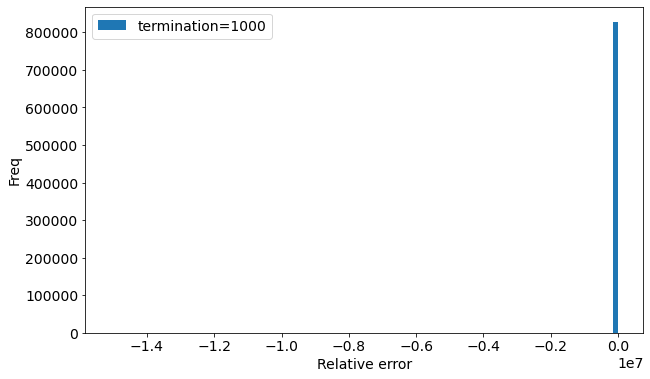

In [207]:
plt.hist((gen_plot-reco_plot_2)/gen_plot, bins=100,  label='termination=1000')
plt.legend()
plt.ylabel('Freq')
plt.xlabel('Relative error')
plt.savefig('alpha_analysis/alpha_2_err.png')
plt.show()

In [208]:
(np.abs((gen_plot-reco_plot_1)/gen_plot)<1).sum()/len(gen_plot)

0.3373226736033884

In [209]:
(np.abs((gen_plot-reco_plot_2)/gen_plot)<1).sum()/len(gen_plot)

0.2649149993714402